In [20]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, fbeta_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from datasets import load_dataset
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [21]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Constants and Setup
SEED = 0
NUM_FEATURES = 6  # Number of features per word
STOP_WORDS = set(stopwords.words("english"))
PUNCTUATION = set(string.punctuation)

In [23]:
# Custom Feature Extraction Function
def extract_features(word, position_ratio):
    """Generate feature vector for each word based on custom characteristics."""
    features = np.zeros(NUM_FEATURES, dtype=np.float32)

    features[0] = 1 if word[0].isupper() else 0  # Is capitalized
    features[1] = 1 if word.isupper() else 0  # All uppercase
    features[2] = len(word)  # Length of word
    features[3] = 1 if word.lower() in STOP_WORDS else 0  # Is stopword
    features[4] = 1 if word in PUNCTUATION else 0  # Is punctuation
    features[5] = position_ratio  # Relative position in sentence

    return features

In [24]:
# Custom Feature Extraction Function
def extract_features(word, position_ratio):
    """Generate feature vector for each word based on custom characteristics."""
    features = np.zeros(NUM_FEATURES, dtype=np.float32)

    features[0] = 1 if word[0].isupper() else 0  # Is capitalized
    features[1] = 1 if word.isupper() else 0  # All uppercase
    features[2] = len(word)  # Length of word
    features[3] = 1 if word.lower() in STOP_WORDS else 0  # Is stopword
    features[4] = 1 if word in PUNCTUATION else 0  # Is punctuation
    features[5] = position_ratio  # Relative position in sentence

    return features

# Data Preparation Function
def process_data(data_split):
    """Process data split into feature vectors and labels."""
    words, feature_matrix, labels = [], [], []

    for entry in tqdm(data_split):
        tokens = entry["tokens"]
        ner_labels = entry["ner_tags"]
        num_tokens = len(tokens)

        for idx, token in enumerate(tokens):
            rel_position = idx / num_tokens  # Position scaling
            feature_vec = extract_features(token, rel_position)

            # Binary label: 1 for entity, 0 for non-entity
            label = 1 if ner_labels[idx] > 0 else 0

            feature_matrix.append(feature_vec)
            labels.append(label)
            words.append(token)

    return np.array(words), np.array(feature_matrix, dtype=np.float32), np.array(labels, dtype=np.int32)

In [25]:
# Load and Prepare Dataset
dataset = load_dataset("conll2003", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

train_words, X_train, y_train = process_data(train_data)
val_words, X_val, y_val = process_data(validation_data)
test_words, X_test, y_test = process_data(test_data)

100%|██████████| 3453/3453 [00:00<00:00, 23121.27it/s]


In [26]:
# Display shapes for verification
print("Train feature shape:", X_train.shape)
print("Validation feature shape:", X_val.shape)
print("Test feature shape:", X_test.shape)

# Display example entities
sample_entities = val_words[y_val == 1]
print("Example Named Entities:")
for word in np.random.choice(sample_entities, size=10):
    print(word)

Train feature shape: (203621, 6)
Validation feature shape: (51362, 6)
Test feature shape: (46435, 6)
Example Named Entities:
OPEN
Colin
Reynard
Gianluigi
Iran
Barvikha
Gough
Telekom
Algeria
Mexican


In [27]:
# Scaling Features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)  # Use same scale for validation and test
X_test = scaler.transform(X_test)

In [28]:
# SVM Classifier Setup and Training
svm_classifier = SVC(C=1.0, kernel="linear", class_weight="balanced", random_state=SEED)
svm_classifier.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=0)

In [29]:
# Model Evaluation on Validation Set
y_pred_val = svm_classifier.predict(X_val)
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val))


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     42759
           1       0.82      0.97      0.89      8603

    accuracy                           0.96     51362
   macro avg       0.91      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



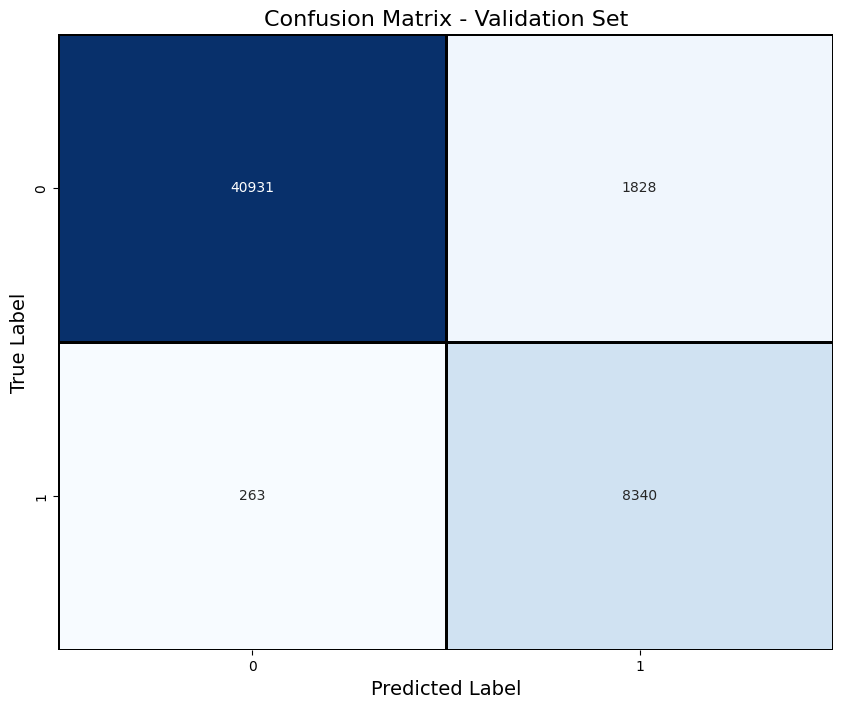

In [30]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=1, linecolor='black')

# Add labels and title for clarity
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Validation Set", fontsize=16)

# Show the plot
plt.show()


In [31]:
# Calculate predictions on the validation set
y_pred_val = svm_classifier.predict(X_val)

# Calculate macro-averaged metrics
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred_val)
precision = precision_score(y_true=y_val, y_pred=y_pred_val, average='macro')
recall = recall_score(y_true=y_val, y_pred=y_pred_val, average='macro')
f1 = f1_score(y_true=y_val, y_pred=y_pred_val, average='macro')

# Calculating F0.5 and F2 scores using beta values
f0_5 = fbeta_score(y_true=y_val, y_pred=y_pred_val, average='macro', beta=0.5)
f2 = fbeta_score(y_true=y_val, y_pred=y_pred_val, average='macro', beta=2.0)

# Print the results
print("Macro Averaging:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f0_5:.4f}")
print(f"F2 Score: {f2:.4f}")


Macro Averaging:
Accuracy: 0.9593
Precision: 0.9069
Recall: 0.9633
F1 Score: 0.9318
F0.5 Score: 0.9162
F2 Score: 0.9499


In [32]:
# Predict Named Entities for Sample Sentences
sample_sentences = [
    "NASA announced a new mission to Mars.",
    "Elon Musk, the CEO of Tesla, is an influential figure.",
    "Google's latest AI advancements are groundbreaking.",
    "COVID-19 vaccination is vital for public health."
]

def classify_sentence(model, scaler, text):
    tokens = word_tokenize(text)
    feature_vectors = []

    for idx, token in enumerate(tokens):
        pos_ratio = idx / len(tokens)
        feature_vector = extract_features(token, pos_ratio)
        feature_vectors.append(feature_vector)

    feature_vectors = scaler.transform(feature_vectors)
    predictions = model.predict(feature_vectors)

    return [(token, int(label)) for token, label in zip(tokens, predictions)]

# Annotate and Display Results for Sample Sentences
print("\nSample Sentence Classification:")
for sentence in sample_sentences:
    annotated = classify_sentence(svm_classifier, scaler, sentence)
    annotated_text = " ".join(f"{word}_{label}" for word, label in annotated)
    print(annotated_text)


Sample Sentence Classification:
NASA_1 announced_0 a_0 new_0 mission_0 to_0 Mars_1 ._0
Elon_1 Musk_1 ,_0 the_0 CEO_1 of_0 Tesla_1 ,_0 is_0 an_0 influential_0 figure_0 ._0
Google_1 's_0 latest_0 AI_1 advancements_0 are_0 groundbreaking_0 ._0
COVID-19_1 vaccination_0 is_0 vital_0 for_0 public_0 health_0 ._0


In [33]:
# Function to classify a sentence and return annotated results
def classify_sentence(input_sentence):
    tokens = word_tokenize(input_sentence)
    feature_vectors = []

    for idx, token in enumerate(tokens):
        pos_ratio = idx / len(tokens)
        feature_vector = extract_features(token, pos_ratio)
        feature_vectors.append(feature_vector)

    feature_vectors = scaler.transform(feature_vectors)
    predictions = svm_classifier.predict(feature_vectors)

    annotated_sentence = " ".join(f"{word}_{int(label)}" for word, label in zip(tokens, predictions))
    return annotated_sentence

# Create a Gradio interface using the updated component calls
iface = gr.Interface(
    fn=classify_sentence,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs=gr.Textbox(),
    title="Named Entity Recognition (NER)",
    description="Enter a sentence to classify tokens as named entities (1) or non-entities (0)."
)

# Launch the Gradio app
iface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
